# IMAGE CLASSIFICATION of the PHOTOS

## Classification of Sad and Happy Photos

### 1) Installation

In [11]:
#Required libraries are installed
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
#TRequired Libraries are imported
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imghdr
import os

In [2]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### 2) Load Data

In [5]:
# data is in the data folder
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [ ]:
# This data has some problematic images. First remove dodgy images
for image_class in os.listdir('data'):
    for image in os.listdir(os.path.join('data', image_class)):
        try:
            img = cv2.imread(os.path.join('data', image_class))
            tip = imghdr.what(os.path.join('data', image_class))
            if tip not in ['jpeg','jpg','bmp','png']:
                os.remove(os.path.join('data', image_class))
        except Exception as e:
            os.remove(os.path.join('data', image_class))

In [7]:
data_iterator = data.as_numpy_iterator()

In [8]:
batch = data_iterator.next()

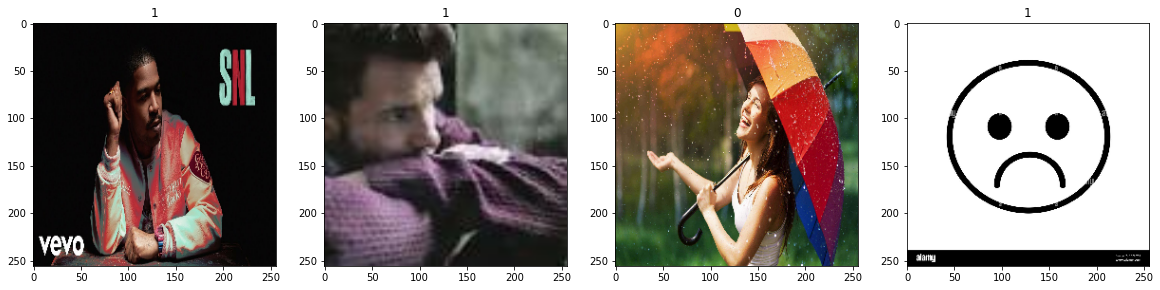

In [9]:
#Happy images has 0 title, sad images has 1 as a title.
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### 3) Scale and Split the Data

In [10]:
# Each pixel is scaled between 0-1
data = data.map(lambda x,y: (x/255, y))

In [12]:
data.as_numpy_iterator().next()

In [13]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### 4) Deep Neural Network Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [16]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

### 5) Train

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [19]:
hist = model.fit(train, epochs=24, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/24
7/7 [==============================] - 11s 771ms/step - loss: 1.5175 - accuracy: 0.4420 - val_loss: 0.6874 - val_accuracy: 0.5000
Epoch 2/24
7/7 [==============================] - 7s 765ms/step - loss: 0.6897 - accuracy: 0.5179 - val_loss: 0.6328 - val_accuracy: 0.6406
Epoch 3/24
7/7 [==============================] - 7s 761ms/step - loss: 0.6815 - accuracy: 0.5223 - val_loss: 0.6571 - val_accuracy: 0.5625
Epoch 4/24
7/7 [==============================] - 7s 793ms/step - loss: 0.6560 - accuracy: 0.5491 - val_loss: 0.6398 - val_accuracy: 0.6250
Epoch 5/24
7/7 [==============================] - 7s 746ms/step - loss: 0.6388 - accuracy: 0.6830 - val_loss: 0.5981 - val_accuracy: 0.6406
Epoch 6/24
7/7 [==============================] - 8s 840ms/step - loss: 0.5979 - accuracy: 0.6741 - val_loss: 0.5442 - val_accuracy: 0.7656
Epoch 7/24
7/7 [==============================] - 8s 819ms/step - loss: 0.5253 - accuracy: 0.7589 - val_loss: 0.4468 - val_accuracy: 0.7656
Epoch 8/24
7/7 [===

### 8) Performance of the Model

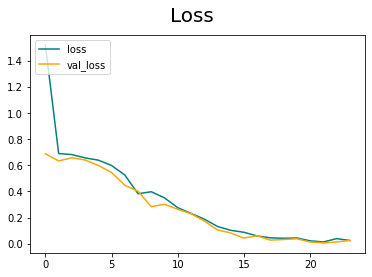

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

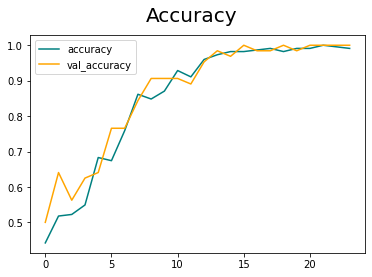

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [23]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [24]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 714ms/step


In [25]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


### 9) Testing the Model 

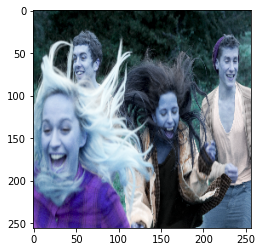

In [26]:
img = cv2.imread('154006829.jpg')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [27]:
test_m = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 275ms/step


In [28]:
if test_m > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


### 11) Model Saving

In [29]:
from tensorflow.keras.models import load_model

In [30]:
model.save(os.path.join('models','imageclassifier.h5'))